# Milestone 2
## Introduction
- Name: Izzan Dienurrahman
- Batch: HCK-003

## Objective
- Classifying types of brain tumor on MRI scanned brain images.

## Problem Statements
- Number of classes
- Size of the images
- Image augmentation
- Best CNN architecture
- Tuning CNN architecture

## Dataset Source
The dataset is taken from kaggle which can be found directly [here](https://www.kaggle.com/datasets/taneemurrehman/brain-tumor-classification)

## Import Libraries
Below are the libraries needed to run this notebook

In [1]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.applications import inception_resnet_v2
from keras.applications import InceptionResNetV2
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import logging
from tensorflow import keras
from keras import layers
import joblib
logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Data Loading
Load Dataset and Split into train-val-test dataset

In [2]:
IMG_SIZE = 256 
image_size = (IMG_SIZE, IMG_SIZE)
batch_size = 32

# prepare train-val set
train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
    "brain-tumor-classification/training",
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2, # train:val = 80:20
    subset="both", # include both training + validation
    shuffle=True, # shuffle the datasets
    seed=42,
    image_size=image_size, #resize the image into 256x256
    batch_size=batch_size, #configure batch size
    crop_to_aspect_ratio=True
)

# # prepare train-val set
# val_ds = tf.keras.utils.image_dataset_from_directory(
#     "brain-tumor-classification/training",
#     labels='inferred',
#     label_mode='categorical',
#     validation_split=0.2, # train:val = 80:20
#     subset="validation", # include both training + validation
#     shuffle=True, # shuffle the datasets
#     seed=33,
#     image_size=image_size, #resize the image into 256x256
#     batch_size=batch_size, #configure batch size
#     crop_to_aspect_ratio=False
# )

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Using 574 files for validation.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-12 01:03:13.775821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-12 01:03:13.775947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# prepare test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    "brain-tumor-classification/testing",
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    crop_to_aspect_ratio=True
)

Found 394 files belonging to 4 classes.


In [4]:
class_names = train_ds.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [5]:
# save target class names
with open('class_names.pkl','wb') as file_1:
    joblib.dump(class_names,file_1)

## Exploratory Data Analysis

2023-02-12 01:03:31.228840: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


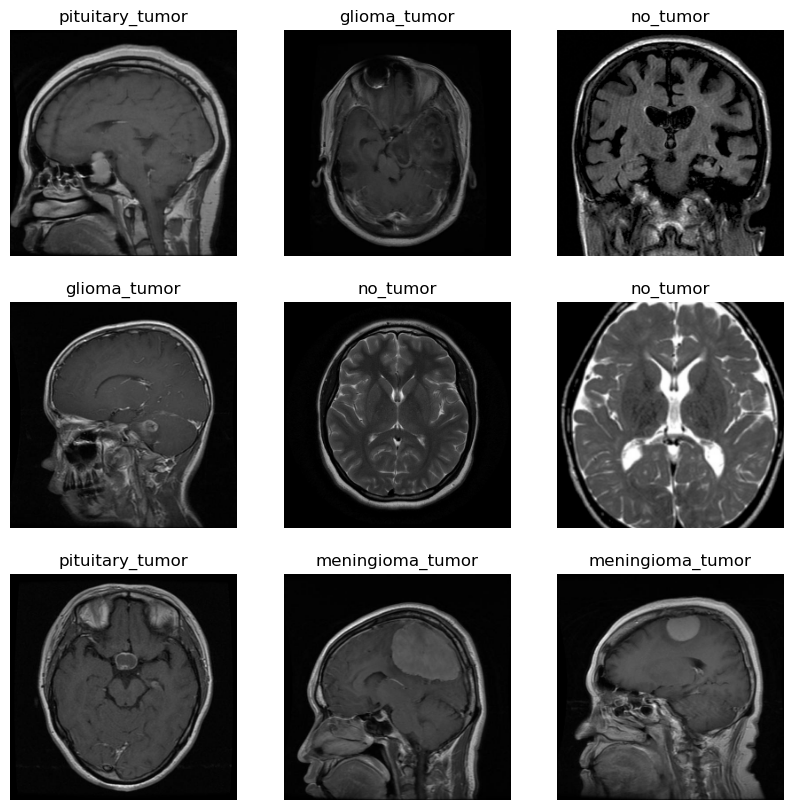

In [5]:
# show images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

There are 4 classes which consists of `pituitary_tumor`, `glioma_tumor`, `meningioma_tumor`, and `no_tumor`

## Data Preprocessing

### Data Augmentation Definition

In [9]:
with tf.device('/cpu:0'):
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal_and_vertical"),
            layers.RandomRotation(0.2,fill_mode="constant"),
            layers.RandomZoom(height_factor=(-0.1,0.1),fill_mode="constant",)
        ],
        name='augmentation_layer'
    )

### Visualize Augmented Data

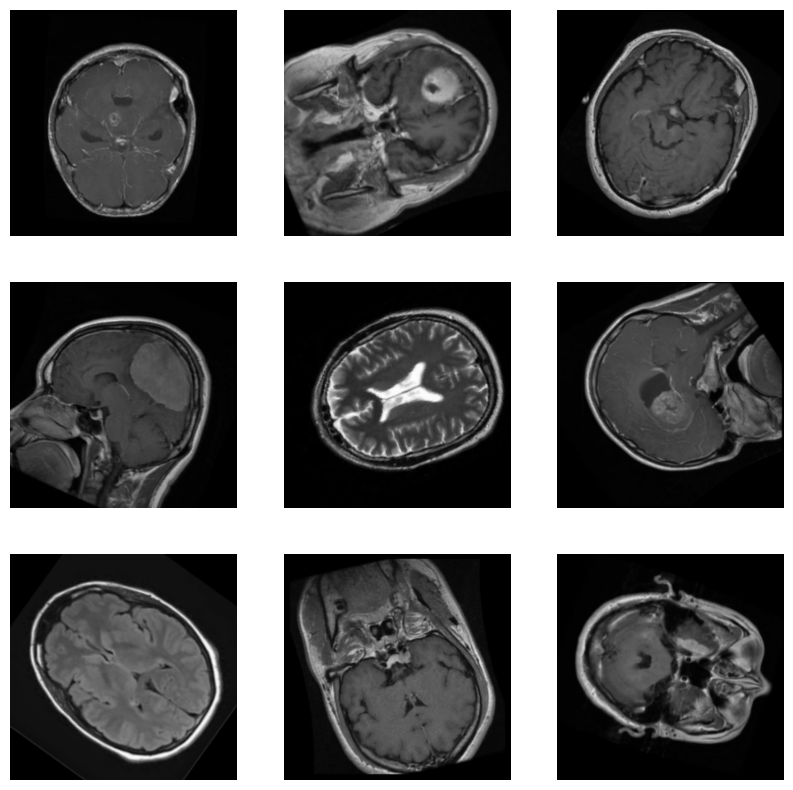

In [10]:
with tf.device('/cpu:0'):
    plt.figure(figsize=(10, 10))
    for images, _ in train_ds.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[i].numpy().astype("uint8"))
            plt.axis("off")

In [9]:
# with tf.device('/CPU:0'):
#     plt.figure(figsize=(10, 10))
#     for images, _ in train_ds_aug.take(1):
#         for i in range(9):
#             augmented_images = data_augmentation(images)
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(augmented_images[i].numpy().astype("uint8"))
#             plt.axis("off")

### Applying Data Augmentation on Train set
Here the augmentation takes place asynchronously on the cpu.

In [8]:
with tf.device('/cpu:0'):
    # Apply `data_augmentation` to the training images.
    train_ds_aug = train_ds.repeat(2).cache().map(
        lambda img, label: (data_augmentation(img), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    ).prefetch(tf.data.AUTOTUNE)

    # Prefetching samples in GPU memory helps maximize GPU utilization.
    val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [7]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

## Baseline CNN Model Definition 

In [8]:
# baseline model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs) # rescaling pixel values
    x = layers.Conv2D(64, 2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes,activation='softmax')(x)

    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=len(class_names))
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
# show model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                         

Above are the summary of the `baseline model`. It has `16.7 Millions` of trainable parameters.

In [10]:
# compile the model behavior
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','Precision','Recall'])

Using `adam` as the loss function and `categorical crossentropy` for optimizer because our target is `multiclass` and `one-hot encoded`

In [11]:
# define callback
callback= [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), # stop the training if no improvement after n times
    ModelCheckpoint('brain_tumor_baseline.h5', monitor='val_loss', save_best_only=True), # save the best model after this callback is executed
]

Add callback to stop the training process in case of stagnant model improvement

## Baseline Model Training

In [12]:
epochs=100 # set number of max epoch
history = model.fit( # fit/train the model
  train_ds, # train-set
  validation_data=val_ds, # val-set
  epochs=epochs, # number of epochs
  callbacks=callback # callback (optional)
)

Epoch 1/100


2023-02-12 00:42:49.146964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 0.8618 - accuracy: 0.6729 - precision: 0.7173 - recall: 0.6067

2023-02-12 00:42:53.629203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 6s 67ms/step - loss: 0.8618 - accuracy: 0.6729 - precision: 0.7173 - recall: 0.6067 - val_loss: 0.8744 - val_accuracy: 0.6794 - val_precision: 0.7815 - val_recall: 0.5296
Epoch 2/100
72/72 [==============================] - 4s 58ms/step - loss: 0.2971 - accuracy: 0.8972 - precision: 0.9171 - recall: 0.8724 - val_loss: 0.6528 - val_accuracy: 0.7683 - val_precision: 0.8561 - val_recall: 0.6324
Epoch 3/100
72/72 [==============================] - 4s 58ms/step - loss: 0.1253 - accuracy: 0.9699 - precision: 0.9745 - recall: 0.9639 - val_loss: 0.5903 - val_accuracy: 0.7282 - val_precision: 0.7600 - val_recall: 0.6951
Epoch 4/100
72/72 [==============================] - 4s 58ms/step - loss: 0.0590 - accuracy: 0.9887 - precision: 0.9904 - recall: 0.9874 - val_loss: 0.5551 - val_accuracy: 0.7770 - val_precision: 0.7981 - val_recall: 0.7439
Epoch 5/100
72/72 [==============================] - 4s 58ms/step - loss: 0.0311 - accuracy: 0.9948 - precision: 0.9

## Baseline Model Evaluation

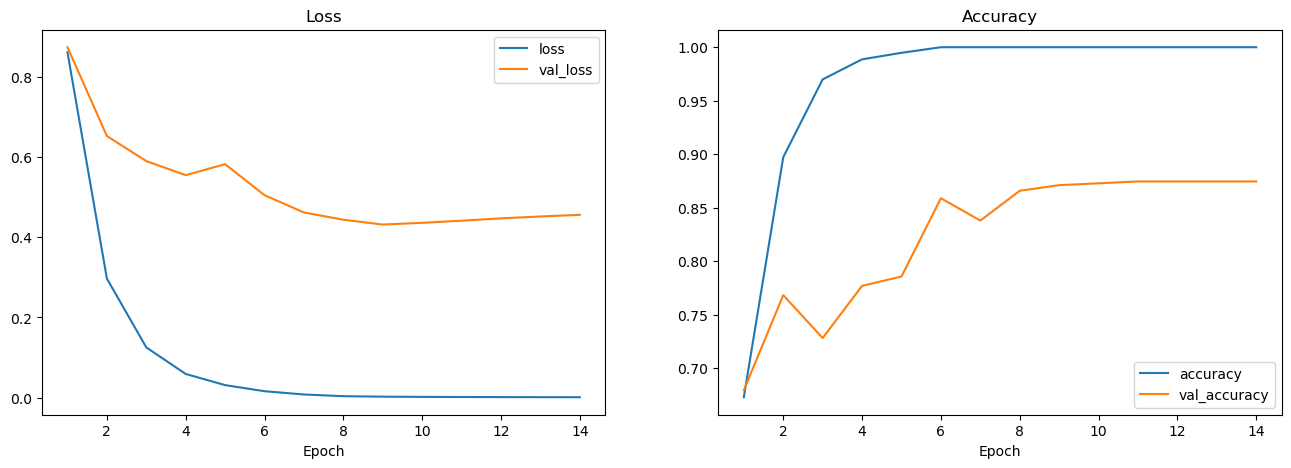

In [13]:
# plot val loss & recall
epoch=len(history.epoch)

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

Loss graph and accuracy graph are all over the places, this baseline model needs to be improved.

In [14]:
model.evaluate(test_ds)

13/13 [==============================] - 1s 35ms/step - loss: 2.4610 - accuracy: 0.6066 - precision: 0.6130 - recall: 0.5990


[2.4610018730163574, 0.606598973274231, 0.6129869818687439, 0.5989847779273987]

Even though the graphs were all over the places it's accuracy towards test-set is quite good, reaching 0.72 in accuracy score.

In [ ]:
y_pred = model.predict(test_ds)

13/13 [==============================] - 1s 35ms/step


In [ ]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
print(classification_report(np.argmax(y_true,axis=1),np.argmax(y_pred,axis=1),labels=[0,1,2,3],target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.26      0.06      0.10       100
meningioma_tumor       0.23      0.23      0.23       115
        no_tumor       0.26      0.47      0.34       105
 pituitary_tumor       0.15      0.14      0.14        74

        accuracy                           0.23       394
       macro avg       0.23      0.22      0.20       394
    weighted avg       0.23      0.23      0.21       394



## Model Improvement
This is my attempt to improve the model, my approaches to tune this model are as follows (not in order):
- Changing number of filters and or neurons.
- Removing layer
- Adding regularizer such as L2
- Adding batch norm layer
- Adding dropout layer
- Change the padding in conv2D layer 

In [15]:
def make_model2(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs) # rescaling pixel values
    x = layers.Conv2D(16, 2, padding='valid', activation='relu',kernel_regularizer='l2')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(16, 2, padding='valid', activation='relu',kernel_regularizer='l2')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes,activation='softmax')(x)

    return keras.Model(inputs, outputs)

model2 = make_model2(input_shape=image_size + (3,), num_classes=len(class_names))
keras.utils.plot_model(model2, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 127, 127, 16)      208       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 16)        1040      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 16)       0         
 2D)                                                       

As summarized above, now the model has only `2 Millions` instead of `16.5 Millions` of parameters like in baseline model. This shows over `8 times smaller` than previous model.

In [17]:
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','Precision','Recall'])

In [18]:
# define callback
callback2= [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('brain_tumor_model_2.h5', monitor='val_loss', save_best_only=True),
]

## Improved Model Training

In [19]:
epochs=100
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback2
)

Epoch 1/100


2023-02-12 00:44:34.828683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 1.3720 - accuracy: 0.4778 - precision: 0.5851 - recall: 0.2875

2023-02-12 00:44:37.585617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 4s 41ms/step - loss: 1.3720 - accuracy: 0.4778 - precision: 0.5851 - recall: 0.2875 - val_loss: 1.2832 - val_accuracy: 0.5261 - val_precision: 0.7808 - val_recall: 0.0993
Epoch 2/100
72/72 [==============================] - 3s 36ms/step - loss: 1.0188 - accuracy: 0.6459 - precision: 0.7930 - recall: 0.4055 - val_loss: 1.1715 - val_accuracy: 0.5819 - val_precision: 0.9438 - val_recall: 0.1463
Epoch 3/100
72/72 [==============================] - 2s 34ms/step - loss: 0.8218 - accuracy: 0.7548 - precision: 0.8864 - recall: 0.5370 - val_loss: 1.0643 - val_accuracy: 0.7003 - val_precision: 0.9592 - val_recall: 0.1638
Epoch 4/100
72/72 [==============================] - 3s 35ms/step - loss: 0.6751 - accuracy: 0.8367 - precision: 0.9250 - recall: 0.6821 - val_loss: 0.9407 - val_accuracy: 0.7578 - val_precision: 0.9203 - val_recall: 0.4024
Epoch 5/100
72/72 [==============================] - 2s 34ms/step - loss: 0.5448 - accuracy: 0.8754 - precision: 0.9

## Improved Model Evaluation

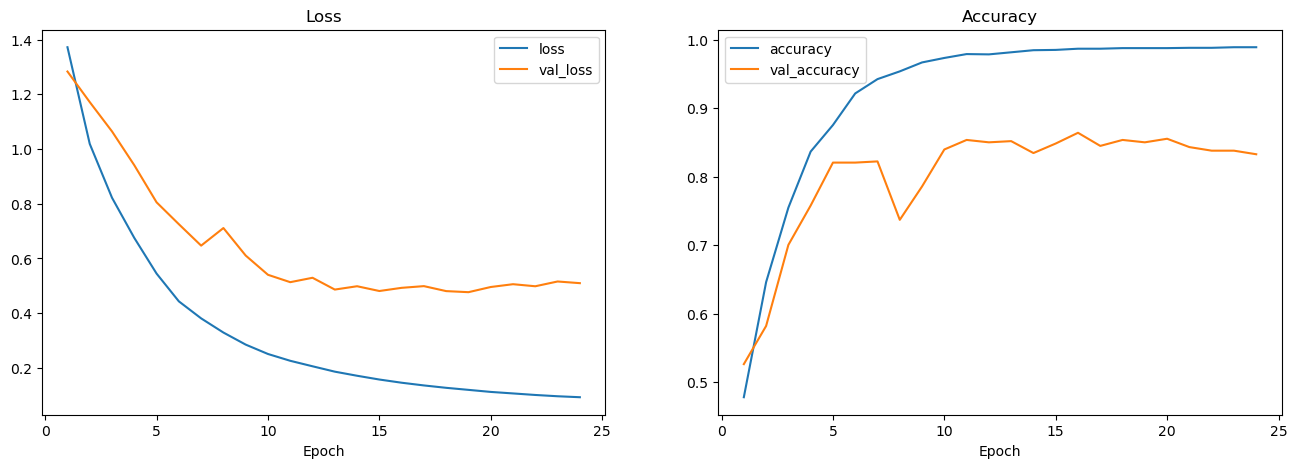

In [20]:
# plot val loss & recall
epoch=len(history2.epoch)

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history2.history['loss'], label='loss')
ax[0].plot(range(1,epoch+1),history2.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history2.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history2.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

In [21]:
model2.evaluate(test_ds)

13/13 [==============================] - 0s 23ms/step - loss: 1.5447 - accuracy: 0.6675 - precision: 0.6965 - recall: 0.6523


[1.544713020324707, 0.6675126552581787, 0.6964769959449768, 0.6522842645645142]

Accuracy and precision are slightly improved

In [ ]:
y_pred2 = model2.predict(test_ds)

13/13 [==============================] - 1s 21ms/step


In [ ]:
print(classification_report(np.argmax(y_true,axis=1),np.argmax(y_pred2,axis=1),labels=[0,1,2,3],target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.26      0.06      0.10       100
meningioma_tumor       0.31      0.37      0.34       115
        no_tumor       0.25      0.38      0.30       105
 pituitary_tumor       0.14      0.14      0.14        74

        accuracy                           0.25       394
       macro avg       0.24      0.24      0.22       394
    weighted avg       0.25      0.25      0.23       394



## Attempts of Using Pre-trained Model: InceptionResNetV2
According to [this](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiGi8iQ74n9AhWlguYKHYKuDgEQFnoECA4QAQ&url=https%3A%2F%2Fjurnal.ugm.ac.id%2Fijitee%2Farticle%2Fdownload%2F62663%2F31493&usg=AOvVaw2cFVC8Mqpu_xWdY0m_M8T0) paper, using CNN as a means to detect MRI brain tumor images is possible and achieved good results. However their dataset is much smaller than what I used here. Their datasets comprises of 253 images which they split into 80% training 10% validation and 10% testing. In comparison, the datasets that I use comprises of 3000+ images.

In [23]:
base_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=image_size+(3,),
    pooling='avg',
)

219055592/219055592 [==============================] - 77s 0us/step


In [24]:
base_model.trainable=False # freeze base model

In [25]:
def make_model3(input_shape, num_classes):
  inputs = keras.Input(shape=image_size + (3,))
  x = inception_resnet_v2.preprocess_input(inputs) # add mandatory preprocess layer
  x = base_model(x)
  x = keras.layers.Dense(8)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.Dropout(0.5)(x)
  outputs = keras.layers.Dense(num_classes,activation='softmax')(x)
  return keras.Model(inputs, outputs)

model3 = make_model3(input_shape=image_size + (3,), num_classes=len(class_names))
keras.utils.plot_model(model3, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 128, 128, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 8)                 12296     
                                                           

In [27]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','Precision','Recall'])

In [28]:
# define callback
callback3= [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ModelCheckpoint('brain_tumor_model_3.h5', monitor='val_loss', save_best_only=True),
]

In [29]:
epochs=100
history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback3
)

Epoch 1/100


2023-02-12 00:50:01.922121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 1.2101 - accuracy: 0.4551 - precision: 0.5931 - recall: 0.2400

2023-02-12 00:50:17.974357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 31s 324ms/step - loss: 1.2101 - accuracy: 0.4551 - precision: 0.5931 - recall: 0.2400 - val_loss: 0.9181 - val_accuracy: 0.6272 - val_precision: 0.8298 - val_recall: 0.4077
Epoch 2/100
72/72 [==============================] - 11s 160ms/step - loss: 0.9373 - accuracy: 0.5902 - precision: 0.7843 - recall: 0.4037 - val_loss: 0.7985 - val_accuracy: 0.6760 - val_precision: 0.8062 - val_recall: 0.5436
Epoch 3/100
72/72 [==============================] - 10s 139ms/step - loss: 0.8409 - accuracy: 0.6272 - precision: 0.8336 - recall: 0.4713 - val_loss: 0.7308 - val_accuracy: 0.7387 - val_precision: 0.8305 - val_recall: 0.6063
Epoch 4/100
72/72 [==============================] - 11s 148ms/step - loss: 0.7789 - accuracy: 0.6494 - precision: 0.8464 - recall: 0.5161 - val_loss: 0.6828 - val_accuracy: 0.7474 - val_precision: 0.8352 - val_recall: 0.6359
Epoch 5/100
72/72 [==============================] - 10s 142ms/step - loss: 0.7271 - accuracy: 0.6725 - prec

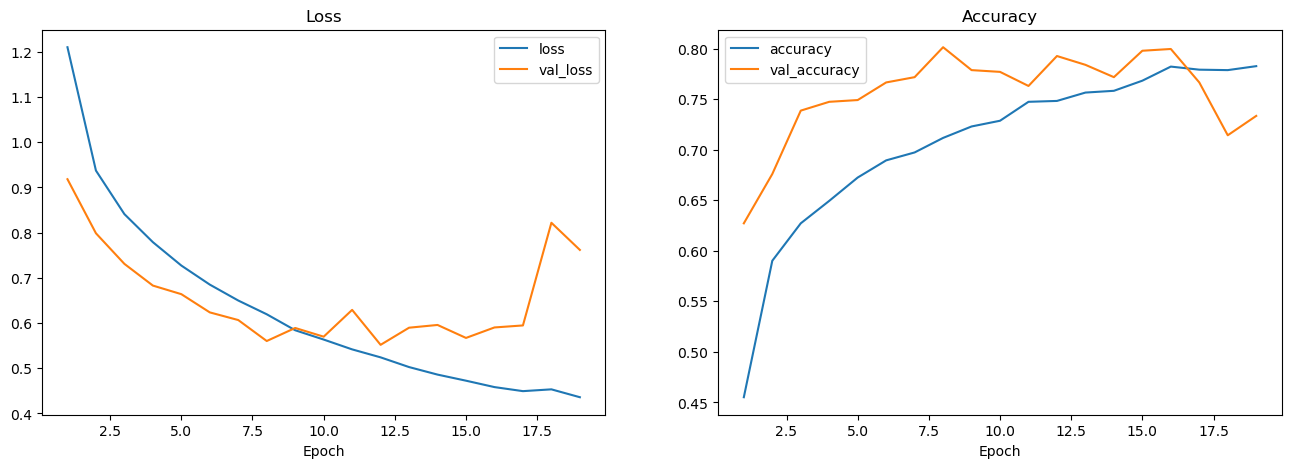

In [30]:
# plot val loss & recall
epoch=len(history3.epoch)

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history3.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history3.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
#ax[0].set_ylim(0,0.01)

ax[1].plot(range(1,epoch+1),history3.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history3.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
#ax[1].set_ylim(0.5,1.5)

plt.show()

In [31]:
model3.evaluate(test_ds)

13/13 [==============================] - 5s 413ms/step - loss: 1.0812 - accuracy: 0.5431 - precision: 0.5953 - recall: 0.4518


[1.081196904182434, 0.5431472063064575, 0.5953177213668823, 0.4517766535282135]

Well, the result is quite dissappointing.. I assume that the pretrained weights are from common images and none from MRI ones. Therefore, it interferes with the results because the frozen weights holds back the presumably "to be updated weights".

## Model Saving
Over 3 created models, the best model are "improved model" in my 2nd attempt. The model is already saved because of the model checkpoint callback before.

## Conclusion
- Deep learning model such as Convolutional Neural Network (CNN) can learn to distinguish images from one to another.
- Preprocessing image data can be simply resizing and rescaling.
- Image data augmentation such as but not limited to flipping, and rotating is helpful to introduce image `variation` form in the model. It is also useful to expand if the sample datasets are limited or few.
- Adding kernel regularizer and trimming the number of neurons helps to reduce model overfitting as shown in improved model.
- In this notebook, `InceptionResNetV2` which is the `pretrained model` along with its weights, does not give the best result, even worse.
- The best model is the `improved model`, reaching `accuracy: 0.7386, precision: 0.7440, and recall: 0.7081` as compared to `baseline` model only reaching `accuracy: 0.7284, precision: 0.7316, recall: 0.7056`
- The `improvement` in all 3 metrics are relatively small or `insignificant`. However the `number of parameter has reduced significantly`, from `16.7 Millions of parameters` in baseline model to only `2 Millions of parameters` in improved model. For relatively the same amount of performance or a tad better, this model is `8x smaller` than before and this is proven with the size of the created models that is `25 MB` instead of `200 MB` for the baseline model, this affects the inference speed later on in model deployment.